In [ ]:
import dlc_bci as bci
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
import math
from torch.autograd import Variable
from torch import nn
from torch import optim
from torch.nn import functional as F
from scipy.ndimage import gaussian_filter1d
import librosa

In [45]:
def preprocessing(data):
    mean,std = torch.mean(data,0),torch.std(data,0)
    data.sub_(mean).div_(std)
    A = Tensor(data.shape[0],data.shape[1],data.shape[2])
    B = Tensor(data.shape[0],data.shape[1],data.shape[2],data.shape[2])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            A[i,j,:] = Tensor(np.fft.fft(data[i,j,:]))
            for z in range(data.shape[2]):
                B[i,j,z,:] = data[i,j,:]
                B[i,j,:,z] = A[i,j,:]
    return B

In [30]:
def data_augmentation(data,method):
    data_transfor = Tensor(data.shape[0], data.shape[1], data.shape[2])
    if method =="noise":
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                #wn = Tensor(np.random.randn(len(data[i,j,:])))
                #data_transfor[i,j,:] = data[i,j,:] +10*wn
                data_transfor[i,j,:] = data[i,j,:]+Tensor(np.random.normal(0, 1,data[i,j,:].shape))
    if method=="roll":
        data_transfor = Tensor(np.roll(data,10,axis=2))
    if method =="stretch":
        rate = 0.6
        input_length = 50
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                data1 = librosa.effects.time_stretch(np.array(data[i,j,:]), rate)
                if len(data1) > input_length:
                    data1 = data1[:input_length]
                else:
                    data1 = np.pad(data1, (0, max(0, input_length - len(data1))), "constant")
                data_transfor[i,j,:] = Tensor(data1)
    return torch.cat([data,data_transfor],0)

In [4]:
def train_model(model,train_input,train_target,mini_batch_size,learning_rate):
    optimizer = optim.Adam(model.parameters(),lr = learning_rate)
    iteration = 1000
    Loss = []
    for i in range(iteration):
        sum_loss = 0
        for n in range(0,train_input.shape[0],mini_batch_size):
            output = model(train_input.narrow(0,n,mini_batch_size))
            loss = F.cross_entropy(output,train_target.narrow(0,n,mini_batch_size))
            model.zero_grad()
            loss.backward()
            sum_loss = loss.data[0] + sum_loss
            Loss.append(sum_loss)
            optimizer.step()
        print(i,' ',sum_loss)
    return Loss

In [5]:
def compute_nb_error(model,data_input,target,mini_batch_size):
    error = 0
    for n in range(0,data_input.shape[0],mini_batch_size):
        output = model(data_input.narrow(0,n,mini_batch_size))
        _,prediction = output.data.max(1)
        for k in range(mini_batch_size):
            if target.data[n+k]!= prediction[k]:
                error +=1
    return error


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        nb_hidden = 64
        self.conv1 = nn.Conv1d(28, 32, kernel_size=5,padding=2)
        #self.batch_nom1= nn.BatchNorm1d(32)
        # self.conv2 = nn.Conv1d(32, 32, kernel_size=5,padding=2)
        # self.batch_nom2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3,padding=1)
        #self.batch_nom3 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(25 * 64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2))
        # x = F.relu(self.batch_nom2(F.max_pool1d(self.conv2(x), kernel_size=2)))
        x = F.relu(self.conv3(x))

        x = F.relu(self.fc1(x.view(-1, 25*64)))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        return x

In [46]:
train_input, train_target = bci.load(root='../data',one_khz=False)
test_input,test_target = bci.load(root='../data',one_khz=False,train=False)
print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])


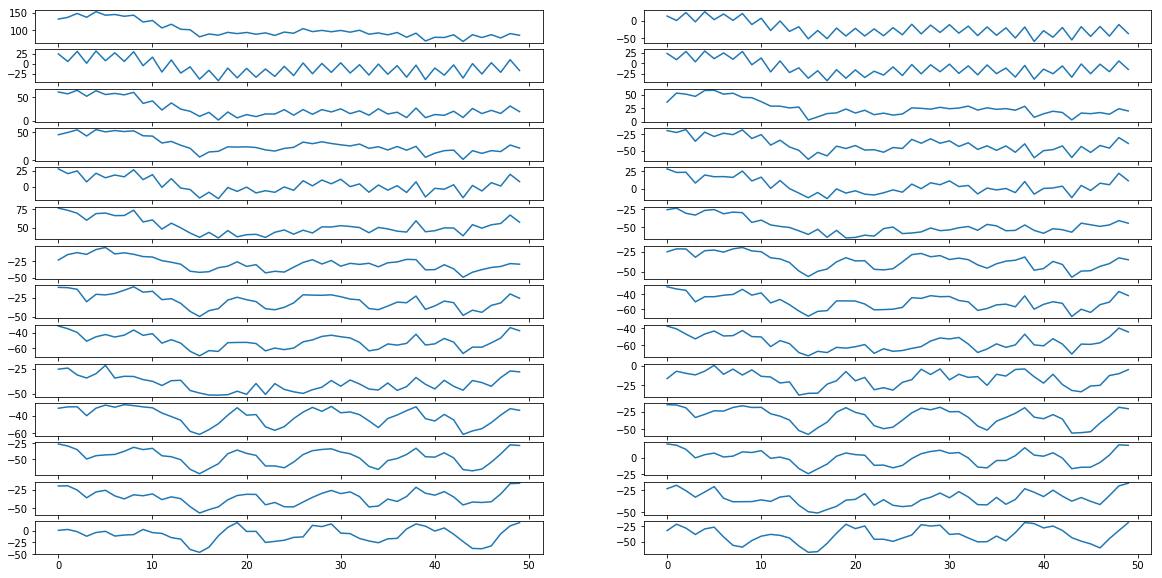

In [42]:
#train_input = preprocessing(train_input,3,0.01)
fig,axe = plt.subplots(14,2,figsize=(20, 10))
for i in range(14):
    axe[i,0].plot(np.array(train_input[1,2*i,:]))
    axe[i,1].plot(np.array(train_input[1,2*i+1,:]))

In [33]:
train_input_aug = data_augmentation(train_input,"stretch")

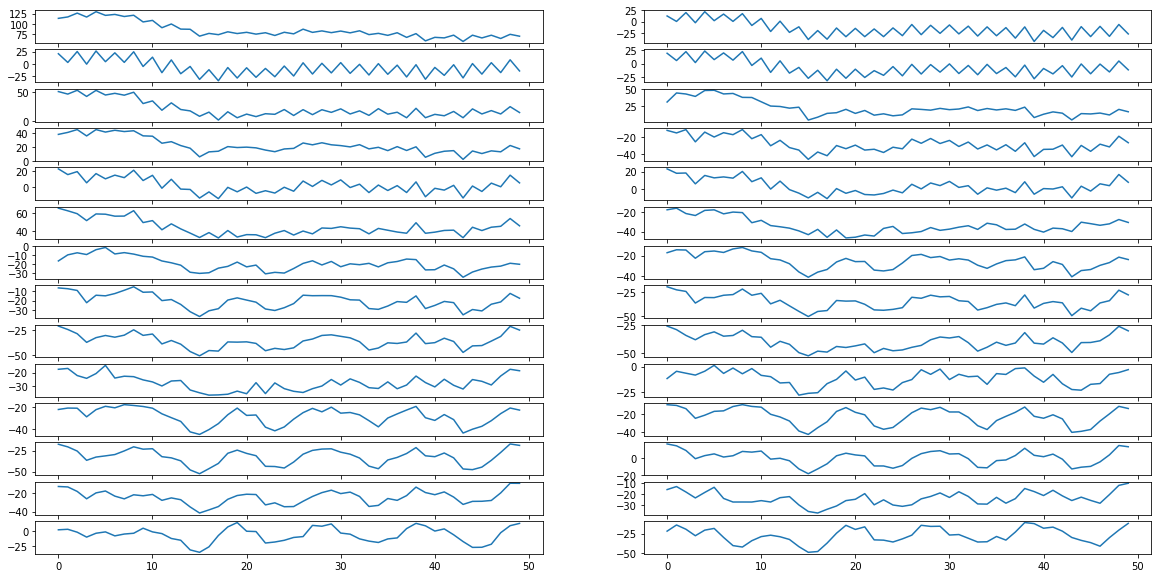

In [34]:
fig,axe = plt.subplots(14,2,figsize=(20, 10))
for i in range(14):
    axe[i,0].plot(np.array(train_input_aug[317,2*i,:]))
    axe[i,1].plot(np.array(train_input_aug[317,2*i+1,:]))

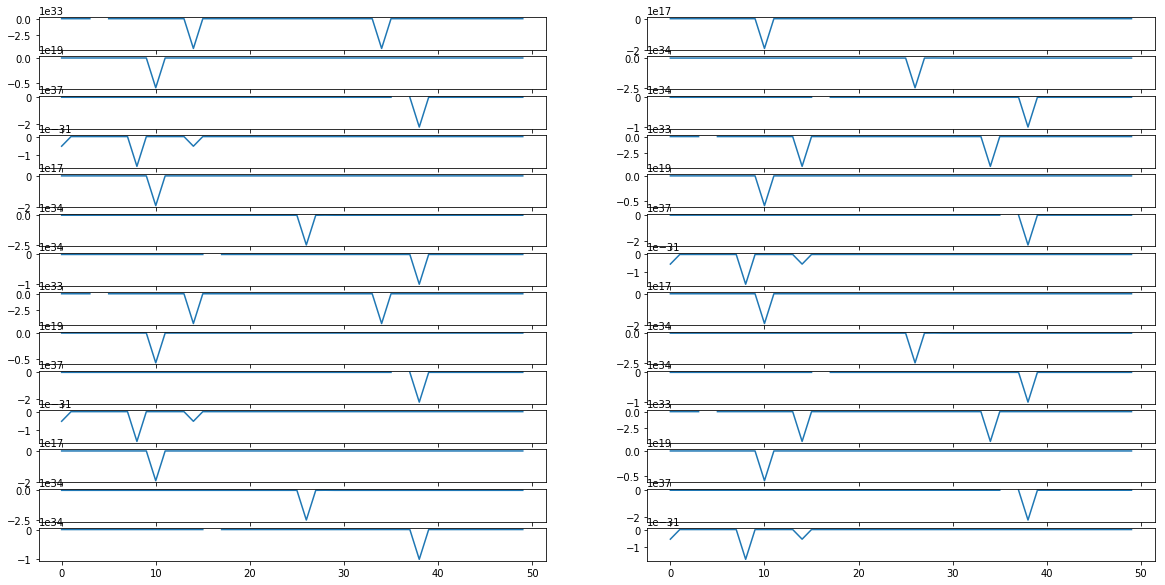

In [43]:
train_input_final = preprocessing(train_input_aug,3,0.01)
fig,axe = plt.subplots(14,2,figsize=(20, 10))
for i in range(14):
    axe[i,0].plot(np.array(train_input_final[317,2*i,:]))
    axe[i,1].plot(np.array(train_input_final[317,2*i+1,:]))

In [44]:
train_input_final.shape

torch.Size([632, 28, 50])

In [36]:
mean,std = torch.mean(train_input,0),torch.std(train_input,0)
train_input = preprocessing(train_input,1,1)

In [ ]:
train_target_final = torch.cat([train_target,train_target],0)
test_input_final = preprocessing(test_input,3,0.01)

In [ ]:
train_input_final = Variable(train_input_final)
train_target_final = Variable(train_target_final)
test_input_final = Variable(test_input_final)
test_target = Variable(test_target)
mini_batch_size = 79
model = Net()
Loss = train_model(model,train_input_final,train_target_final,mini_batch_size)
plt.plot(Loss)
plt.show()
error = compute_nb_error(model,train_input_final,train_target_final,79,0.01)
print(100*(1-error/train_target_final.shape[0]))
error = compute_nb_error(model,test_input_final,test_target,20)
print(100*(1-error/test_target.shape[0]))